In [5]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import pytesseract

In [52]:
img = cv2.imread('/home/vietlq4/PaddleOCR/cropper/yolov5/warped.png')
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

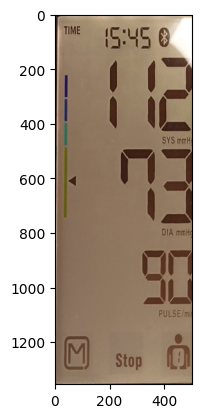

In [53]:
plt.imshow(img)

In [54]:
img1 = img[150:450,:,:]

In [55]:
cv2.imwrite('im1.jpg', img1)

True

In [43]:
tesseract_config = r'--oem 3 --psm 13'
result_dict = pytesseract.image_to_data(img)

In [44]:
result_dict

'level\tpage_num\tblock_num\tpar_num\tline_num\tword_num\tleft\ttop\twidth\theight\tconf\ttext\n1\t1\t0\t0\t0\t0\t0\t0\t502\t1355\t-1'

In [56]:
import os

In [57]:
os.listdir('/home/vietlq4/PaddleOCR/data/')

['android', 'iphone']

In [1]:
def find_missing_idx(list_idxs):
        for i in range(0, 4):
            if i not in list_idxs:
                return i

def append_missing_point(list_corners):
    list_idxs = [corner[0] for corner in list_corners.items()]
    # list_points = [corner[0] for corner in list_corners]
    missing_idx = find_missing_idx(list_idxs)

    #  top_left: 0, top_right 1, bottom_left 2, bottom_right 3
    # missed corner is top_left
    if missing_idx == 0:
        #  (top_right + bottom_left) / 2
        midpoint = np.add(list_corners[1], list_corners[2]) // 2
        x = 2 * midpoint[0] - list_corners[3][0]
        y = 2 * midpoint[1] - list_corners[3][1]
    # missed corner is top_right
    elif missing_idx == 1:
        # (top_left+ bottom_right) /2
        midpoint = np.add(list_corners[0], list_corners[3]) // 2
        x = 2 * midpoint[0] - list_corners[2][0]
        y = 2 * midpoint[1] - list_corners[2][1]

    # missed corner is bottom_left
    elif missing_idx == 2:
        #  (top_left + bottom_right)/ 2
        midpoint = np.add(list_corners[0], list_corners[3]) // 2
        x = 2 * midpoint[0] - list_corners[1][0]
        y = 2 * midpoint[1] - list_corners[1][1]

    # missed corner is bottom right
    else:
        #  (top_right + bottom_left) / 2
        midpoint = np.add(list_corners[1], list_corners[2]) // 2
        x = 2 * midpoint[0] - list_corners[0][0]
        y = 2 * midpoint[1] - list_corners[0][1]

    list_corners[missing_idx] = (x, y)

    return list_corners

In [2]:
import glob
import os
import pickle
import xml.etree.ElementTree as ET
from os import listdir, getcwd
from os.path import join

dirs = ['train', 'val', 'test']

classes = ['top_left', 'top_right', 'bottom_left', 'bottom_right']


def getImagesInDir(dirPath):
    imageList = []
    for root, dirs, files in os.walk(dirPath):
        for file in files:
            if file.endswith('.jpg'):
                imageList.append(os.path.join(root, file))
    return imageList


def convert(size, box):
    dw = 1./(size[0])
    dh = 1./(size[1])
    x = (box[0] + box[1])/2.0 - 1
    y = (box[2] + box[3])/2.0 - 1
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x, y, w, h)

def center_point(box):
    center_x = (box[0] + box[1])// 2
    center_y = (box[2] + box[3]) // 2
    return (center_x, center_y)


def convert_annotation(dir_path, output_path, image_path):
    print(image_path)
    basename = os.path.basename(image_path)
    dir_path = image_path.replace(basename, '')
    output_path = dir_path.replace('images', 'labels')
    os.makedirs(output_path, exist_ok=True)
    basename_no_ext = os.path.splitext(basename)[0]
    in_file = open(dir_path + basename_no_ext + '.xml')
    out_file = open(output_path + basename_no_ext + '.txt', 'w')
    print(output_path)
    tree = ET.parse(in_file)
    root = tree.getroot()
    size = root.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)
    
    list_corners = {}

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in classes or int(difficult) == 1:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text), float(
            xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
        
        list_corners[cls_id] = center_point(b)
    
    if len(list_corners) == 3:
        list_corners = append_missing_point(list_corners)
        
    return list_corners
        
        
        # # bb = convert((w, h), b)
        # out_file.write(str(cls_id) + " " +
        #                " ".join([str(a) for a in bb]) + '\n')




In [3]:
import csv

In [6]:
cwd = getcwd()

for dir_path in dirs:
    full_dir_path = './datasets/customdata/images/' + dir_path
    # print(full_dir_path)
    output_path = './customdata/labels/' + dir_path + '/'

    if not os.path.exists(output_path):
        os.makedirs(output_path)

    image_paths = getImagesInDir(full_dir_path)
    list_file = open(full_dir_path + '.csv', 'w')

    writer = csv.writer(list_file, delimiter="|", quoting=csv.QUOTE_MINIMAL)
    for image_path in image_paths:
        list_corners = convert_annotation(full_dir_path, output_path, image_path)
        if len(list_corners) < 4:
            continue
        try:
            x0, y0 = str(int(list_corners[0][0])),str(int(list_corners[0][1]))
            x1,y1 = str(int(list_corners[1][0])),str(int(list_corners[1][1]))
            x2,y2 = str(int(list_corners[3][0])),str(int(list_corners[3][1]))
            x3,y3 = str(int(list_corners[2][0])),str(int(list_corners[2][1]))
        except KeyError as e:
            print(e)
        writer.writerow([os.path.basename(image_path),'6345156902f42f88911fb98a','2022-10-11 07:04:09.132000',x0,y0,x1,y1,x2,y2,x3,y3,'screen'])
        
    list_file.close()

    print("Finished processing: " + dir_path)


./datasets/customdata/images/train/android/fora/VID_20221012_113653/fora_VID_20221012_113653_iframe780.jpg
./datasets/customdata/labels/train/android/fora/VID_20221012_113653/
./datasets/customdata/images/train/android/fora/VID_20221012_113653/fora_VID_20221012_113653_iframe510.jpg
./datasets/customdata/labels/train/android/fora/VID_20221012_113653/
./datasets/customdata/images/train/android/fora/VID_20221012_113653/fora_VID_20221012_113653_iframe1020.jpg
./datasets/customdata/labels/train/android/fora/VID_20221012_113653/
./datasets/customdata/images/train/android/fora/VID_20221012_113653/fora_VID_20221012_113653_iframe870.jpg
./datasets/customdata/labels/train/android/fora/VID_20221012_113653/
./datasets/customdata/images/train/android/fora/VID_20221012_113653/fora_VID_20221012_113653_iframe990.jpg
./datasets/customdata/labels/train/android/fora/VID_20221012_113653/
./datasets/customdata/images/train/android/fora/VID_20221012_113653/fora_VID_20221012_113653_iframe750.jpg
./datasets/c